# HyperPerimeter Tuning for the above model...
## pip install keras-tuner

In [ ]:
import sqlite3 as sql
from keras.src.models import Sequential 
from keras.src.layers import Dense, Dropout, Input
from keras_tuner import RandomSearch 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from keras.src.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.src.utils import to_categorical
import pandas as pd 
import pickle as pkl

In [24]:
## Spliting data into train and test data

## Read the raw data from sql table.

conn = sql.connect('../DataBase/TrainingData.db')
query="SELECT * FROM HealthData"
df = pd.read_sql_query(query, conn)

df = df.dropna(subset=['NObeyesdad'])  # Remove rows where the target is missing


## Defining the numerical, ordinal and nominal features.
num_cols = [col for col in df.columns if df[col].dtype != 'object']

nominal_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

ordinal_cols = [ 'CALC', 'CAEC']

target_col = ['NObeyesdad']

## Building pipeline for data transformation

# For numerical features: impute with median and scale the data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For nominal features: impute with most frequent and encoded respectively 
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])

# For nordinal features: impute with most frequent and encoded respectively 
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OrdinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


# ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('nom', nominal_transformer, nominal_cols),
        ('ord', ordinal_transformer, ordinal_cols),
    ]
)

target_category_rank = {
    'Normal_Weight': 1,
    'Insufficient_Weight': 2,
    'Overweight_Level_I': 3,
    'Overweight_Level_II': 4,
    'Obesity_Type_I': 5,
    'Obesity_Type_II': 6,
    'Obesity_Type_III': 7
}

df['NObeyesdad'] = df['NObeyesdad'].replace(target_category_rank)
# Fit the preprocessor on the training data
# Fit and transform the features

df_transformed = preprocessor.fit_transform(df)


C:\Users\jayku\AppData\Local\Temp\ipykernel_19284\3688986210.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['NObeyesdad'] = df['NObeyesdad'].replace(target_category_rank)


In [25]:
# Extract feature names from the transformers
# For numerical features, the feature names remain the same
num_feature_names = num_cols

# For nominal features, extract feature names from OneHotEncoder
nominal_feature_names = preprocessor.transformers_[1][1].named_steps['OneHotEncoder'].get_feature_names_out(nominal_cols)

# For ordinal features, the feature names remain the same
ordinal_feature_names = ordinal_cols

# Combine all feature names
inputs_feature_names = num_feature_names + nominal_feature_names.tolist() + ordinal_feature_names


input_df = pd.DataFrame(df_transformed, columns=inputs_feature_names)
input_df.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SMOKE_yes,SCC_no,SCC_yes,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,CALC,CAEC
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0


In [31]:
X=input_df
y=df['NObeyesdad']
x_train,  x_test, y_train , y_test =train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:

y_train_hp_cat = to_categorical(y_train)
y_test_hp_cat = to_categorical(y_test)

y_test_hp_cat.shape

(423, 8)

In [38]:
## Define the model-building function 

def build_model(hp):
    
    model = Sequential()
    
    # Input layer with tunable number of neurone
    model.add(Input(shape=(x_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32),
                    activation='relu'))
    
    # first hidden layer with tunable units and dropout
    model.add(Dense(units=hp.Int('units_hidden1', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_hidden1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # second hidden layer
    model.add(Dense(units=hp.Int('unit_hidden2', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('unit_dropout2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # third hidden layer 
    model.add(Dense(units=hp.Int('unit_hidden3', min_value=16, max_value=64, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('unit_dropout3', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(y_train_hp_cat.shape[1], activation='softmax'))
    
    # Compie the model with a tunable learning rate
    model.compile(optimizer=Adam( learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [39]:
## Initialize the tuner 

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='hyperparameter_tuning',
                     project_name='Obesity Classification')

In [40]:
## Start the search using your training data and validation data.

tuner.search(x_train, y_train_hp_cat, epochs=100, validation_split=0.2)

Trial 5 Complete [00h 01m 17s]
val_accuracy: 0.5670611262321472

Best val_accuracy So Far: 0.9773175319035848
Total elapsed time: 00h 06m 25s


In [46]:
## Selecting the best model.

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)


Best hyperparameters: {'units_input': 32, 'units_hidden1': 224, 'dropout_hidden1': 0.2, 'unit_hidden2': 32, 'unit_dropout2': 0.4, 'unit_hidden3': 48, 'unit_dropout3': 0.4, 'learning_rate': 0.01}


d:\Anaconda3\envs\Obesity_venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [48]:
## evaluate on test data
test_loss, test_accuracy = best_model.evaluate(x_test, y_test_hp_cat)
print(f"Test accuracy of the best model: {test_accuracy:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9441 - loss: 0.1972 
Test accuracy of the best model: 0.95


# Building the ANN model with the hyper perimeters

In [50]:
## Building the ANN model

model=Sequential()

## Input layer
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],) ))

## hidden and dropout layer 1
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))

## hidden and dropout layer 2
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))

## hidden and dropout layer 3
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))

## Output Layer.
model.add(Dense(8, activation='softmax'))


# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

history = model.fit(x_train, y_train_hp_cat, epochs=500, batch_size=32, validation_split=0.2)

Epoch 1/500


d:\Anaconda3\envs\Obesity_venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2562 - loss: 1.8797 - val_accuracy: 0.5296 - val_loss: 1.0130
Epoch 2/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4948 - loss: 1.1581 - val_accuracy: 0.7692 - val_loss: 0.7109
Epoch 3/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5983 - loss: 0.9413 - val_accuracy: 0.8402 - val_loss: 0.5282
Epoch 4/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6299 - loss: 0.8364 - val_accuracy: 0.8876 - val_loss: 0.4643
Epoch 5/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7303 - loss: 0.6681 - val_accuracy: 0.8225 - val_loss: 0.4729
Epoch 6/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7705 - loss: 0.6428 - val_accuracy: 0.8787 - val_loss: 0.3569
Epoch 7/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7763 - loss: 0.5834 - val_accuracy: 0.8373 - val_loss: 0.4058
Epoch 8/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7555 - loss: 0.5658 - val_accuracy: 0.9201 - val_loss: 0.3

In [51]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_hp_cat)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8936 - loss: 0.5710
Test Loss: 0.6633191108703613
Test Accuracy: 0.8936170339584351


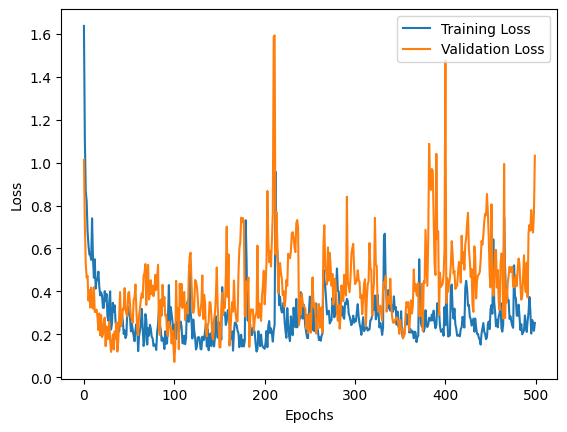

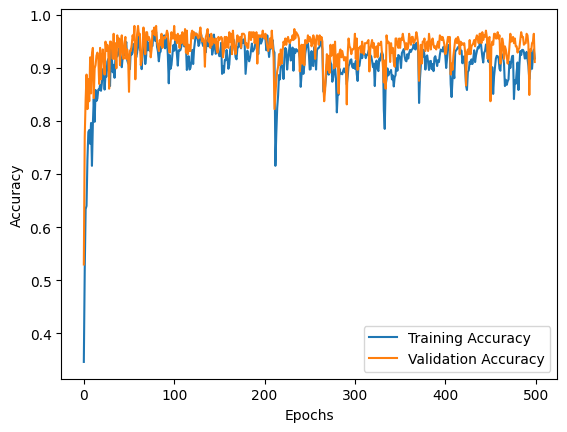

In [52]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

* The gap between the training loss and validation loss (0.2348 vs. 1.0325) is an important sign of overfitting. Overfitting occurs when the model learns patterns that are specific to the training set, rather than general patterns that can apply to unseen data.

# How to Improve Generalization:
- Regularization: Techniques like L1/L2 regularization, dropout (for neural networks), or data augmentation (for image data) can help reduce overfitting.

In [53]:
from keras.src.callbacks import EarlyStopping
from keras.src.regularizers import L2


## Building the ANN model again with L2 regularizers to reduce the Overfitting.

model=Sequential()

## Input layer
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=L2(0.001) ))

## hidden and dropout layer 1
model.add(Dense(224, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.2))

## hidden and dropout layer 2
model.add(Dense(32, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.4))

## hidden and dropout layer 3
model.add(Dense(48, activation='relu', kernel_regularizer=L2(0.001)))
model.add(Dropout(0.4))

## Output Layer.
model.add(Dense(8, activation='softmax'))



# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
## Train the model

history = model.fit(x_train, y_train_hp_cat, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/500


d:\Anaconda3\envs\Obesity_venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3008 - loss: 1.9345 - val_accuracy: 0.7219 - val_loss: 0.9328
Epoch 2/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5907 - loss: 1.1882 - val_accuracy: 0.8107 - val_loss: 0.6816
Epoch 3/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6637 - loss: 0.9304 - val_accuracy: 0.8373 - val_loss: 0.5646
Epoch 4/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7116 - loss: 0.7943 - val_accuracy: 0.8846 - val_loss: 0.5222
Epoch 5/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7382 - loss: 0.7037 - val_accuracy: 0.9201 - val_loss: 0.4028
Epoch 6/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7711 - loss: 0.6577 - val_accuracy: 0.8964 - val_loss: 0.4314
Epoch 7/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8053 - loss: 0.6432 - val_accuracy: 0.9320 - val_loss: 0.4138
Epoch 8/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8149 - loss: 0.6132 - val_accuracy: 0.8225 - val_loss: 0.

In [55]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_hp_cat)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9422 - loss: 0.3022 
Test Loss: 0.2931874096393585
Test Accuracy: 0.9479905366897583


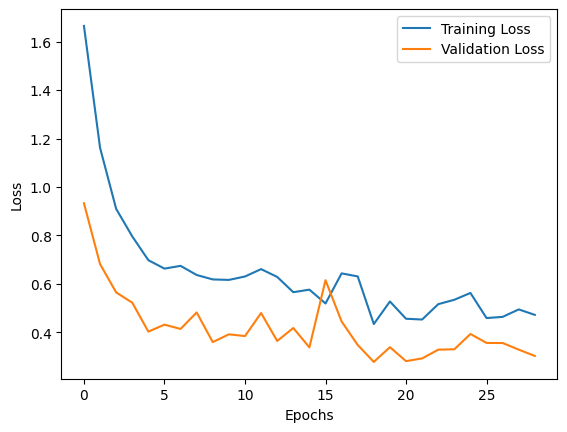

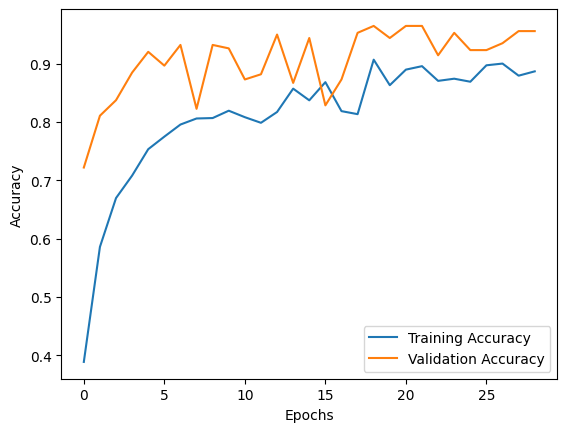

In [56]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Key Observations:

1. Improved Validation Performance:

    - The validation accuracy (95.56%) is now higher than the training accuracy (90.70%). This is a good sign that the model is generalizing better and is not overfitting.
    - The validation loss (0.3022) is also lower than the training loss (0.4246), which suggests that the model's performance on the validation set is better than its performance on the training set, indicating good generalization.
2. Effect of Early Stopping:

    - Early stopping prevents the model from continuing to train after it reaches a point where the validation loss starts to increase, which helps avoid overfitting. This is evident in the fact that the validation performance improved, and the model has become more balanced between training and validation.
3. Effect of L2 Regularization:

    - L2 regularization (weight decay) reduces overfitting by penalizing large weights. This is particularly useful when you have a large number of parameters in your model. By reducing the magnitude of the weights, the model is less likely to fit noise in the training data and can generalize better.
    - The improved validation loss (from 1.0325 to 0.3022) suggests that L2 regularization has effectively helped the model generalize better to unseen data.